## **informations**



**Dear Teams,**

This document provides a template for your work to create an LSTM based model that serves as a backend for an IDS system that filters malicious messages detected in the internal CAN network of a car. You should create a model that does binary classification on CAN message frames.

0 - non-malicious

1 - malicious/ (in this case) fuzzing messages


You should be able to solve the task by only editing 'TODO' parts. Please don't make any changes to the remaining code snippets.

**Solutions**

If you are ready with your solutions please send the models, as well as the finalised jupiter notebooks with outputs and the documentations to our contact email address.

**Contact us**

If you may have any questions send us an email: msgplaut.hu@gmail.com

**Useful links**

LSTM-Based Intrusion Detection System for In-Vehicle Can Bus Communications: https://ieeexplore.ieee.org/abstract/document/9216166\

A curated CAN dataset for automotive intrusion detection: https://www.sciencedirect.com/science/article/pii/S0167404824000786#se0310
(This is the source of the datasets provided by us)

Multivariate Time Series Classification Tutorial with LSTM in PyTorch, PyTorch Lightning and Python: https://www.youtube.com/watch?v=PCgrgHgy26c
(Watch out! In your solution you should be using tensorflow with keras)

How LSTM Networks Work?: https://www.youtube.com/watch?v=guqgmVqcy2c

## **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## **Loading the dataset**

In [2]:
# Load dataset
dff = pd.read_csv('fuzzing-1-forester.csv')
dfi = pd.read_csv('fuzzing-1-impala.csv')
dfs = pd.read_csv('fuzzing-1-silverado.csv')

dff.shape

(660170, 4)

In [3]:
df = pd.concat([dff, dfi, dfs])

## **Data Preprocessing:**

In [4]:
# Define a function that handles the empty string case
def safe_convert_hex(x):
    if pd.isna(x) or x == '':
        return 0  # Return 0 for missing values
    try:
        return int(str(x), 16)  # Ensure x is a string before converting
    except ValueError:
        print(f"Error converting {x} to int")
        return 0  # Return 0 for any other conversion errors



In [5]:
# Convert timestamp to float
df['timestamp'] = df['timestamp'].astype(float)

# Convert arbitration_id and data_field from hexadecimal to integers
df['arbitration_id'] = df['arbitration_id'].apply(safe_convert_hex)
df['data_field'] = df['data_field'].apply(safe_convert_hex)

# Extract features and labels
X = df[['arbitration_id', 'data_field']].values
y = df['attack'].values
print(len(X))

1859362


In [6]:
print(X[:5])

[[3.38000000e+02 1.79885028e+19]
 [3.56000000e+02 2.88230376e+17]
 [3.28000000e+02 7.99670960e+17]
 [3.29000000e+02 8.93549293e+18]
 [3.42000000e+02 1.08086391e+17]]


**Normalizing features**

In [7]:
# Normalize features with scaler
# Initialize the scaler
scaler = StandardScaler()

# Apply the scaler to the features
X_scaled = scaler.fit_transform(X)



In [8]:
print(X_scaled[:5])

[[-0.35304924  3.00764396]
 [-0.2997958  -0.53477834]
 [-0.38263448 -0.43242181]
 [-0.37967596  1.19583094]
 [-0.34121514 -0.57083124]]


**Applying SMOTE to create balanced dataset**

In [9]:
# Apply SMOTE to create balanced dataset
# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Print the shape of the resampled data
print(f"Original dataset shape: {X_scaled.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}")


Original dataset shape: (1859362, 2)
Resampled dataset shape: (3471616, 2)


**Sequence Creation**

In [10]:
# Define the sequence length
sequence_length = 10

# Create sequences
def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []

    for i in range(len(X) - seq_length):
        # Take a sequence of length `seq_length`
        X_seq.append(X[i:i+seq_length])
        # The corresponding label for the sequence will be the label of the last timestep
        y_seq.append(y[i + seq_length - 1])

    # Convert to numpy arrays
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    return X_seq, y_seq


**Creating sequences after resampling**


In [11]:
# Create sequences after resampling
X_seq, y_seq = create_sequences(X_resampled, y_resampled, sequence_length)

In [12]:
# Print the shape of the sequences to check if they are correct
print(f"Shape of X_seq: {X_seq.shape}")
print(f"Shape of y_seq: {y_seq.shape}")

Shape of X_seq: (3471606, 10, 2)
Shape of y_seq: (3471606,)


**Spliting the data into training and testing sets**

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
# Print the size of the training and testing sets
print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')


Training set size: 2777284
Test set size: 694322


In [14]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras', # Path where the model will be saved
    monitor='val_loss',       # Quantity to monitor
    save_best_only=True,      # Save only the best model
    verbose=1                 # Verbosity mode (1 = progress bar)
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Quantity to monitor
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    verbose=1                 # Verbosity mode
)

## **Defining a deeper LSTM model**

In [15]:
# Define a deeper LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(sequence_length, 2)))  # sequence_length=10, features=2
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=32, return_sequences=False))  # Output final hidden state
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid for binary classification


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compiling the model**

In [16]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

**Visualizing the model**

In [18]:
!pip3 install keras-visualizer
from keras_visualizer import visualizer
import matplotlib.image as mpimg
visualizer(model, file_format='png', view=True)

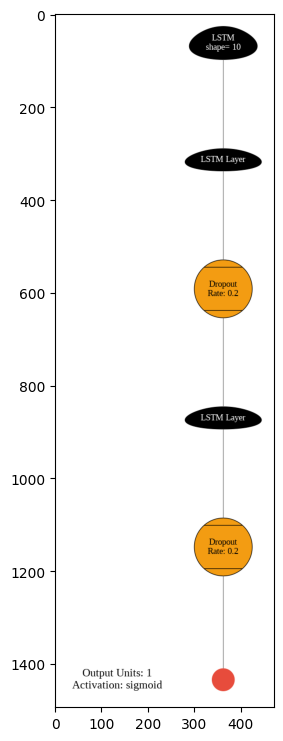

In [19]:
%matplotlib inline
img = mpimg.imread('graph.png')
fig = plt.figure(figsize=[20,9])
plt.imshow(img)
plt.show()

## **Training the model**

In [20]:
# Train the model

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1                   # 1 for progress bar, 2 for just line per epoch
)


Epoch 1/20
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9585 - loss: 0.1150
Epoch 1: val_loss improved from inf to 0.06227, saving model to best_model.keras
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 320s 7ms/step - accuracy: 0.9585 - loss: 0.1150 - val_accuracy: 0.9778 - val_loss: 0.0623
Epoch 2/20
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9777 - loss: 0.0631
Epoch 2: val_loss improved from 0.06227 to 0.04840, saving model to best_model.keras
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.9777 - loss: 0.0631 - val_accuracy: 0.9827 - val_loss: 0.0484
Epoch 3/20
43387/43396 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9817 - loss: 0.0520
Epoch 3: val_loss improved from 0.04840 to 0.04148, saving model to best_model.keras
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.9817 - loss: 0.0520 - val_accuracy: 0.9851 - val_loss: 0.0415
Epoch 4/20
43391/43396 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9836 - loss: 0.0465
Epoch 4: val_loss im

## **Evaluation of the model Accuracy (Accuracy)**

In [21]:
   # Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


21698/21698 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.9922 - loss: 0.0224
Test Accuracy: 0.9924


**Making a predection on the test dataset**

In [22]:
# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(y_pred.shape)

21698/21698 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step
(694322, 1)


**Computing the matrics for the evaluation**

Precision: 0.9954
Recall: 0.9894
F1 Score: 0.9924


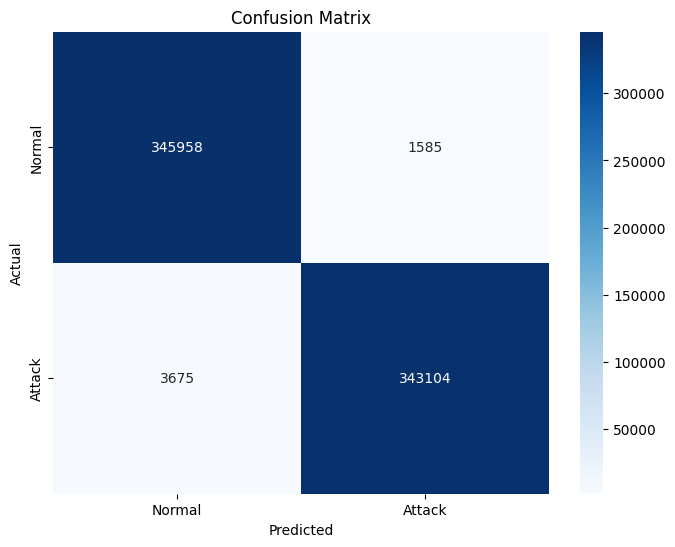

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Compute metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Precision
print(f'Precision: {precision:.4f}')

# Recall
print(f'Recall: {recall:.4f}')

# F1 Score
print(f'F1 Score: {f1:.4f}')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))

## **Testing on external data**

In [ ]:
# Load dataset
df_test = pd.read_csv('fuzzing-1-traverse.csv')
df_test.shape

In [ ]:
# Convert timestamp to float
df_test['timestamp'] = df_test['timestamp'].astype(float)

# Convert arbitration_id and data_field from hexadecimal to integers
# TODO arbitration_id
# TODO data_field (sepcial coversion: in case of empty strings return '0' as placeholder)

# Extract features and labels
X = df_test[['arbitration_id', 'data_field']].values
y = df_test['attack'].values
print(len(X))

In [ ]:
# Normalize features with scaler
# TODO

In [ ]:
X_sequence, y_sequence = create_sequences(X, y, 10)

In [ ]:
y_predicted = (model.predict(X_sequence) > 0.5).astype("int32")
print(y_predicted.shape)

In [ ]:
loss, accuracy = model.evaluate(X_sequence, y_sequence)
print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
# Compute metrics
# precision = ...
# recall = ...
# f1 = ...

#Precision
print(f'Precision: {precision:.4f}')

#Recall
print(f'Recall: {recall:.4f}')

#F1 Score
print(f'F1 Score: {f1:.4f}')

# Compute the confusion matrix
# cm = ...

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()